# The problem

You are given a dataset of customers who have applied for credit.
Each customer is associated with some number of attributes, and a rating of being a Good/Bad credit risk.

## The dataset

- The dataset is given in the file "credit_data.csv".
- Each row corresponds to one customer.
- There are 20 attributes, some numeric and some categorical.
- The last column "Credit Risk" encodes whether the customer was judged to be a Good/Bad credit risk
    - 1: Good credit risk
    - 2: Bad credit risk

You will use this data to come up with a model that predicts "Credit Risk" for a customer from the customer's attributes.

### Attributes

A description of the attributes is given in the plain text file "credit_data_attributes.txt".

You will notice that the values for many attributes are encoded as strings.
For example, attribute 7 is the customer's Employment Status, having possible values
A71, A72, .., A75.  Per the file, "A71" means the customer is unemployed.

#### Currency

The currency units are "DM" (old German currency: the Deutsche Mark).

As you might guess: this data is not recent; you may find anachronisms other than the currency.

# Your submission

There are some ground rules, mainly to make grading easier for the GA and instructor.

Your `sklearn` model should be stored in the variable `credit_model`; this will allow the GA to apply `sklearn` methods to this variable to evaluate your predictions, e.g.
>`credit_model.predict( ... )`

Your submission must contain a Jupyter notebook in a file named
>LastName_FirstName_MidTerm_Project.ipynb

where `LastName` and `FirstName` should be replaced with your name (as it appears on the class roster).

**IF** your submission consists of files in addition to this one notebook, you can submit a *single* zip file.  This file **must** conform to the following rules:
- The notebook must execute, unchanged, when unzipped into *an arbitrary directory*
    - This means that all paths, e.g., to data files or modules, must be *relative* and not absolute.
    

## <font color=Blue>Import Modules

In [2]:
#Importing packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

#Model pre-cursor
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV

#For running model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#For model metrices
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve,fbeta_score,roc_auc_score

## <font color=Blue>Getting the data 
You may obtain the train and test datasets from the repository using code from the following cell.

**NOTE** You may need to change the NOTEBOOK_ROOT variable to point to the directory into which you've cloned the repository.  On my machine, it is `~/Notebooks/NYU`.

In [3]:
NOTEBOOK_ROOT = "~/Notebooks/NYU"

credit_data = pd.read_csv( os.path.join(NOTEBOOK_ROOT, "credit_data.csv") ,na_values=' ')

###### <font color=Orange>Renaming Data and creating Target variable 1 for Good Risk, 0 for Bad Risk

In [4]:
#Renaming columns
credit_data.rename(columns={'Attribute 1':'check_acc',	'Attribute 2':'dur',	'Attribute 3':'credit_hist',
                           'Attribute 4':'loan_purpose',	'Attribute 5':'loan_amount',	'Attribute 6':'saving_acc',
                           'Attribute 7':'employment_status',	'Attribute 8':'installment_rate',
                           'Attribute 9':'status_sex',	'Attribute 10':'debtor_guarantor',
                           'Attribute 11':'present_residence_since',	'Attribute 12':'property',	'Attribute 13':'age',
                           'Attribute 14':'other_installment',	'Attribute 15':'housing_status',
                           'Attribute 16':'existing_credits',	'Attribute 17':'job_status',	'Attribute 18':'count_liable_people',
                           'Attribute 19':'telephone_status',	'Attribute 20':'foreign_worker','Credit Risk':'target'},inplace=True)

#Replacing Bad Credit Risk(2) with 0 to make it binary. 1 is Good Risk and 0 is Bad Risk
credit_data = credit_data.replace({"target": {2:0}})

## <font color=Blue>Understanding Data

###### <font color=Orange>Snapshot of data

In [5]:
credit_data.head()

,check_acc,dur,credit_hist,loan_purpose,loan_amount,saving_acc,employment_status,installment_rate,status_sex,debtor_guarantor,...,property,age,other_installment,housing_status,existing_credits,job_status,count_liable_people,telephone_status,foreign_worker,target
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,0


###### <font color=Orange>Content of data showing variable type and count

In [6]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
check_acc                  1000 non-null object
dur                        1000 non-null int64
credit_hist                1000 non-null object
loan_purpose               1000 non-null object
loan_amount                1000 non-null int64
saving_acc                 1000 non-null object
employment_status          1000 non-null object
installment_rate           1000 non-null int64
status_sex                 1000 non-null object
debtor_guarantor           1000 non-null object
present_residence_since    1000 non-null int64
property                   1000 non-null object
age                        1000 non-null int64
other_installment          1000 non-null object
housing_status             1000 non-null object
existing_credits           1000 non-null int64
job_status                 1000 non-null object
count_liable_people        1000 non-null int64
telephone_status           1000 non-n

###### <font color=Orange>Summary of Numeric parameters

In [7]:
credit_data.describe()

,dur,loan_amount,installment_rate,present_residence_since,age,existing_credits,count_liable_people,target
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,0.700000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,0.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,0.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,1.000000


###### <font color=Orange>Summary of Categorical parameters

In [8]:
credit_data.describe(include=['object'])

,check_acc,credit_hist,loan_purpose,saving_acc,employment_status,status_sex,debtor_guarantor,property,other_installment,housing_status,job_status,telephone_status,foreign_worker
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,4,5,10,5,5,4,3,4,3,3,4,2,2
top,A14,A32,A43,A61,A73,A93,A101,A123,A143,A152,A173,A191,A201
freq,394,530,280,603,339,548,907,332,814,713,630,596,963


#### <font color=Green>The attributes have the following meaning:
 -	check_acc: Status of existing checking account
         - A11 :      ... <    0 DM
         - A13 : 0 <= ... <  200 DM
         - A13 :      ... >= 200 DM /salary assignments for at least 1 year
         - A14 : no checking account
    
 -	dur: Duration (in month) of loan
 
 -	credit_hist: Credit history
	     - A30 : no credits taken/all credits paid back duly
         - A31 : all credits at this bank paid back duly
	     - A32 : existing credits paid back duly till now
         - A33 : delay in paying off in the past
	     - A34 : critical account/ other credits existing (not at this bank
         
 -	loan_purpose: Purpose
	     - A40 : car (new)
	     - A41 : car (used)
	     - A42 : furniture/equipment
	     - A43 : radio/television
	     - A44 : domestic appliances
	     - A45 : repairs
	     - A46 : education
	     - A47 : (vacation - does not exist?)
	     - A48 : retraining
	     - A49 : business
	     - A410 : others

 -	loan_amount: Credit amount
 
 -	saving_acc: Savings account/bonds
	     - A61 :          ... <  100 DM
	     - A62 :   100 <= ... <  500 DM
	     - A63 :   500 <= ... < 1000 DM
	     - A64 :          .. >= 1000 DM
         - A65 :   unknown/ no savings account
         
 -	employment_status: Present employment since
 -	installment_rate: Installment rate in percentage of disposable income
 -	Status_Sex: Personal status and sex
 -	debtor_guarantor: Other debtors / guarantors
	     - A101 : none
	     - A102 : co-applicant
	     - A103 : guarantor
         
 -	present_residence_since: Present residence since (takes value 1,2,3 or 4)
 -	property: Property
	     - A121 : real estate
	     - A122 : if not A121 : building society savings agreement/life insurance
         -  A123 : if not A121/A122 : car or other, not in attribute 6
	     - A124 : unknown / no property
 -	age: Age in years
 -	other_installment: Other installment plans 
	     - A141 : bank
	     - A142 : stores
	     - A143 : none
 -	housing_status: Housing
	     - A151 : rent
	     - A152 : own
	     - A153 : for free
 -	existing_credits: Number of existing credits at this bank
 -	job_status: Job
	     - A171 : unemployed/ unskilled  - non-resident
	     - A172 : unskilled - resident
	     - A173 : skilled employee / official
	     - A174 : management/ self-employed/highly qualified employee/ officer
 -	count_liable_people: Number of people being liable to provide maintenance for
 -	telephone_status: Telephone
	     - A191 : none
	     - A192 : yes, registered under the customers name
 -	foreign_worker: foreign worker
	     - A201 : yes
	     - A202 : no

# <font color=Blue>Splitting Data into Train and Test
 - Splitting into 80% and 20% since there are just 1000 observations in total

In [9]:
train_data=credit_data.sample(frac=0.8,random_state=4321)
test_data=credit_data.drop(train_data.index)

len(train_data)

800

# <font color=Blue>Data Analysis
Checking relationship between target and parameters

###### <font color=Orange> Plot Target vs Categorical Parameters

In [10]:
def bar_cat(parameter,target,dataset):
    """
    Plot/print the distribution of Categorical Parameters with respect to target
    
    Input
    ----------
    parameter: List of attributes (i.e., column names)
    target: y-axis for all the plots
    dataset: DataFrame
    
    Output
    ----------
    Give bar plot for each categorical parameter vs Target variable 
    """
    
    for i, j in enumerate(parameter):
        dataset=dataset.sort_values(by=[j])
        sns.barplot(x=j,y=target,data=dataset)    
        plt.show()

C:\Users\rupal\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


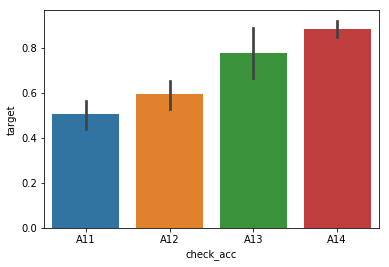

C:\Users\rupal\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


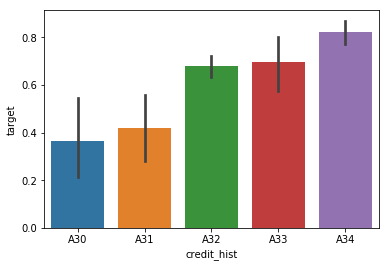

C:\Users\rupal\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


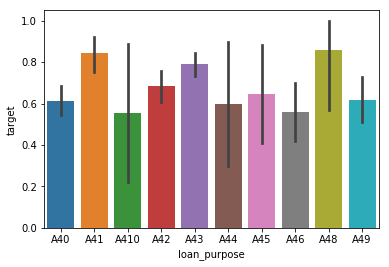

C:\Users\rupal\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


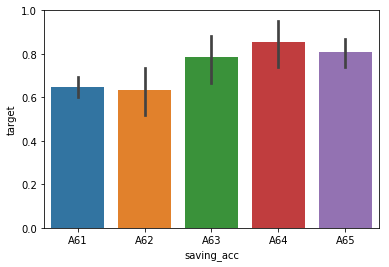

C:\Users\rupal\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


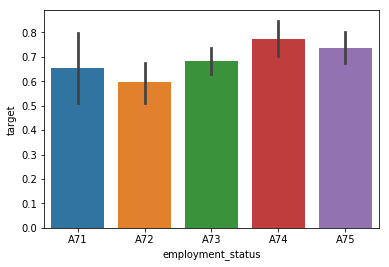

C:\Users\rupal\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


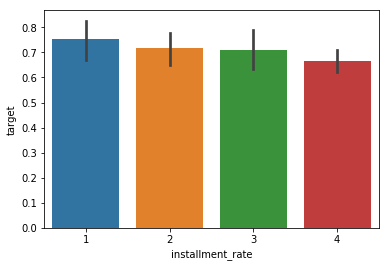

C:\Users\rupal\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


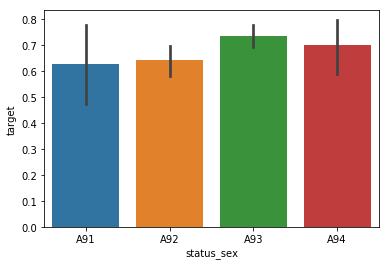

C:\Users\rupal\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


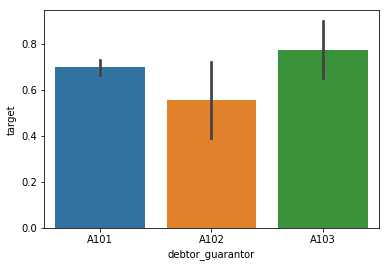

C:\Users\rupal\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


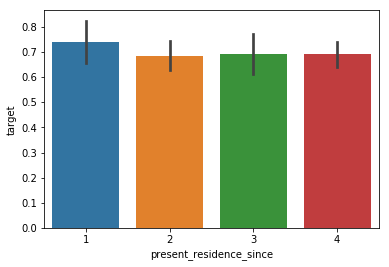

C:\Users\rupal\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


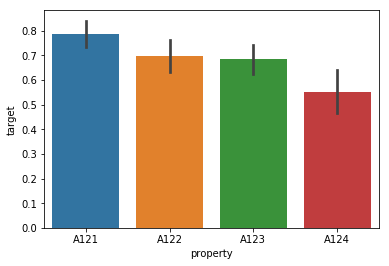

C:\Users\rupal\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


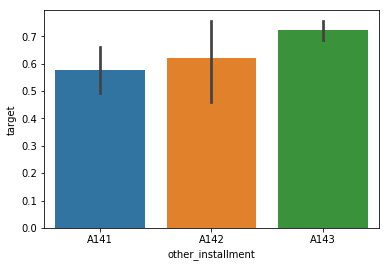

C:\Users\rupal\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


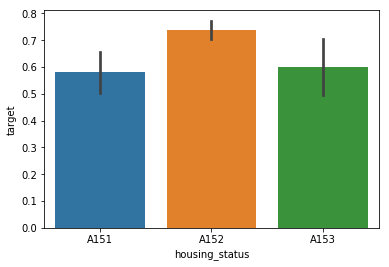

C:\Users\rupal\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


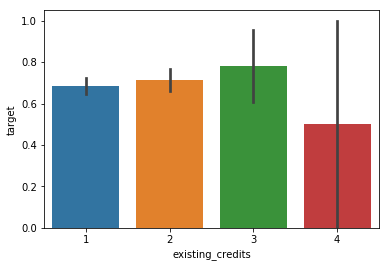

C:\Users\rupal\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


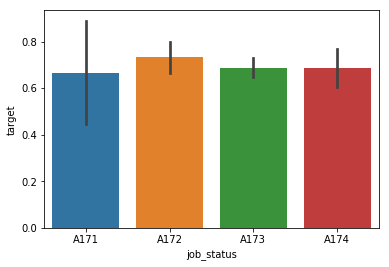

C:\Users\rupal\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


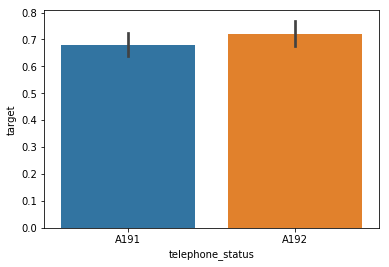

C:\Users\rupal\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


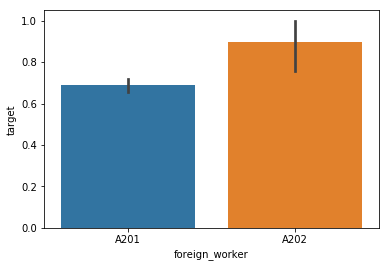

C:\Users\rupal\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


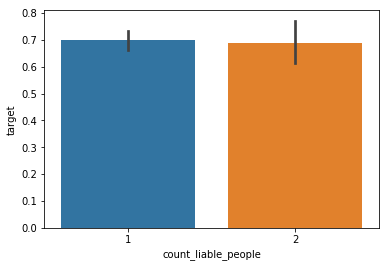

In [11]:
bar_cat(['check_acc','credit_hist','loan_purpose','saving_acc','employment_status','installment_rate','status_sex',
         'debtor_guarantor','present_residence_since','property','other_installment','housing_status',
         'existing_credits','job_status','telephone_status','foreign_worker','count_liable_people'],
        'target',train_data)

##### <font color=Orange>Plot Target vs Numeric Parameters

In [12]:
def bar_num(parameter,target,dataset,bins):
    """
    Plot/print the distribution of Numerican Parameters with respect to target
    
    Input
    ----------
    parameter: List of attributes (i.e., column names)
    target: y-axis for all the plots
    dataset: DataFrame
    bins: Number of bins 
    
    Output
    ----------
    Give bar plot for each numerical parameter vs Target variable 
    """
    
    for i, j in enumerate(parameter):
        dataset['bin_parameter']=pd.qcut(dataset[j], bins)
        Good_risk_prob=dataset.groupby('bin_parameter').agg({target:'mean'})
        sns.barplot(x=Good_risk_prob.index,y=target,data=Good_risk_prob)
        plt.xticks(rotation=90),plt.xlabel(j)
        plt.show()
        dataset.drop('bin_parameter', axis=1,inplace=True)


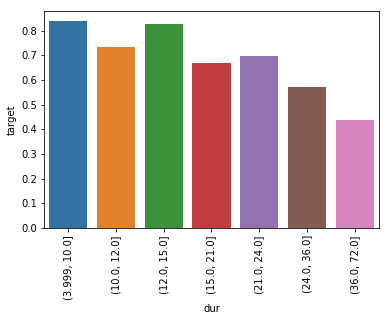

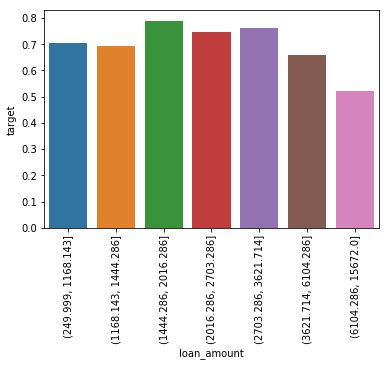

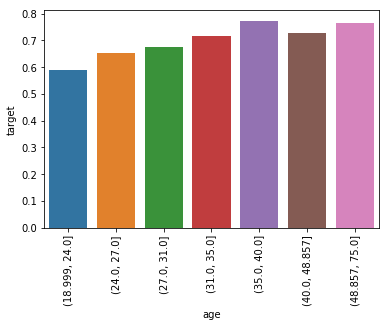

In [13]:
bar_num(['dur','loan_amount','age'],'target',train_data,7)

##### <font color=Orange>Conditional Relationship between 2 parameters vs Survival probability

In [14]:
def bar_mixed(parameter1,parameter2,target,dataset):
    """
    Plot/print barplot of 2 parameters vs target to see if there exists any conditional relationship 
    
    Input
    ----------
    parameter1: first parameter for for x-axis
    parameter2: second parameter for additional plots
    target: y-axis for all the plots
    dataset: DataFrame
    
    Output
    ----------
    Give bar plot 
    """

    sns.catplot(x=parameter1, y =target,  col=parameter2,data=train_data,kind="bar", height=3, aspect=.8)
    plt.show()

(0, 15672)

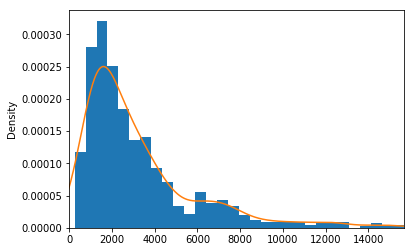

In [15]:
#Distribution of 'Loan Amount'
train_data["loan_amount"].hist(bins=30, density=True, stacked=True)
train_data["loan_amount"].plot(kind='density')

plt.xlim(0,train_data["loan_amount"].max())

##### <font color=Green>Conclusion of Data Analysis Section
 - **Checking Account**: Riskiness decreases as amount in saving account increases. Also, applicants with no checking account are least risky which can not be explained. So this parameter can be split into 2 parameters as: (1) No saving account; (2) With saving account and different balance buckets
 - **Saving Account**: Customers with less than 500DM in their savings account are more risky than customers with higher balance or no saving account. New parameter creation same as Checking Account parametrs
 - **Credit History**: Critical account/credits in other bank are good risk, customers with all credits paid back fully is bad risk. This seems counter-intuitive but this is what data shows
 - **Loan Purpose**: When loan is taken for buying used car, radio/television or for retraining, they are good credit risk, when its for education and new car, it is bad credit risk                                               
 - **Employment Status**: Customers with no job or less than 1 year of job experience are more riskier than experienced customers, but the trend is not linear. This parameter can be split into '<1 year or no job' and '>1 year' job experience
 - **Loan installment rate**: Riskiness increases with increasing installment rate. Good Risk: 1>2>3>4
 - **Status/Sex**: Divorced/Seperated Male or Divorced/Seperated/Married Female are more risky than singles or married male, maybe because they have less obligations and expenses
 - **Debtor/Gurantor**: Customers with gurantor are good risk compared to other applicants
 - **Present residence since**: This parameter doesnt hold much variation in terms of risk. Can drop this variable
 - **Property**: It seems to be a important variable in terms of variation in risk depending on holding property (good risk) and not holding any property (bad risk). Can be treated as numeric variable. Good Risk: A11>A12>A13>A14
 - **Other Installment**: Applicants with no other loans are less risky than applicants with loan. And applicants with bank loans are more risky tahn store loans.Can be treated as numeric variable. Good Risk: A141<A42<A43
 - **Housing Status**: Applicants with their own house are less risky. Can be divided into 2 parameters: 'Own home' ond 'Not Own'
 - **Existing Credits in this bank**: Riskiness decreases with increasing credits till 3, and then riskiness increases for 4 credits in the bank. More number of credit from the bank shows loyalty to the bank, but if it is too high, then it suggests bad risk. So this parameter can be split into 2 parameters as: (1) Between 1 to 3 credits; (2) >3 credits
 - **Job Status**: Not much variation in risk and kind of unintuitive. Can drop this variable
 - **Telephone**: Applicants with phone are slightly less risky than without phone
 - **Foreign Worker**: Foreign workers are more riskier than citizens
 - **Count of liable people**: Not much information in this parameter
 - **Duration**: Higher the duration of the loan, more riskier it gets as probability of default increases for longer period compared to short period
 - **Loan amount**: Not much variation in risk except for very high loan amount which has high risk because of large exposure amount. Binary variable with loan amount>10,000 and <10,000 where 10,000 is between min and max value of loan amount (approx)
 - **Age**: Decreasing riskiness with increasing age which is intuitive as older people have good credit history and have more experience and savings

# <font color=Blue>Data Transformation
 - Converting categorical variable into binary using get_dummies
 - Creating new variables from raw variables as per discussion in Data Analysis Section

#####  <font color=Orange>Creating dummies for categorical parameters

In [16]:
def dummies(parameter,dataset):
    
    for i, var in enumerate(parameter):
        dataset=pd.get_dummies(dataset,columns=[var])         
    
    return (dataset)

In [17]:
train_data=dummies(['loan_purpose','status_sex','debtor_guarantor','other_installment'],train_data)
test_data=dummies(['loan_purpose','status_sex','debtor_guarantor','other_installment'],test_data)

####  <font color=Orange>Creating new parameters

In [18]:
for data in [train_data,test_data]:

    #Spline Split Method for "Checking Account". Treating A11,A12,A13 as continuous variable with values 1,2,3 respectively and A14 as seperate variable       
    data['with_check_acc'] = data['check_acc'].str[-1].astype(int)
    data.loc[data['with_check_acc']==4, 'with_check_acc'] = 0

    data['no_check_acc'] = data['check_acc'].str[-1].astype(int)
    data.loc[data['no_check_acc'] != 4, 'no_check_acc'] = 0
    data.loc[data['no_check_acc']==4, 'no_check_acc'] = 1

    #Spline Split Method for "Saving Account". Treating A61,A62,A63,A64 as continuous variable with values 1,2,3,4 respectively and A65 as seperate variable       
    data['with_saving_acc'] = data['saving_acc'].str[-1].astype(int)
    data.loc[data['with_saving_acc']==5, 'with_saving_acc'] = 0

    data['no_saving_acc'] = data['saving_acc'].str[-1].astype(int)
    data.loc[data['no_saving_acc'] != 5, 'no_saving_acc'] = 0
    data.loc[data['no_saving_acc']==5, 'no_saving_acc'] = 1

    #"Credit History" Treating as quantitative variable with riskiness: 0>1>2>3>4>5
    data['credit_hist'] = data['credit_hist'].str[-1].astype(int)

    #"Property" Treating as quantitative variable with riskiness: 4>3>2>1
    data['property'] = data['property'].str[-1].astype(int)

    #"Housing" Treating as Binary Variable with 'Own House' or 'Not own House'
    data['housing_own'] = data['housing_status'].str[-1].astype(int)
    data.loc[data['housing_own']!=2, 'housing_own'] = 0
    data.loc[data['housing_own']==2, 'housing_own'] = 1

    #Spline Split Method for "Existing Credits in the bank". Treating 1,2,3 credits as continuous and 4 credits as seperate variable
    data['existing_credits_1to3'] = data['existing_credits'].astype(int)

    data['existing_credits_4'] = data['existing_credits'].astype(int)
    data.loc[data['existing_credits_4'] != 4, 'existing_credits_4'] = 0
    data.loc[data['existing_credits_4']==4, 'existing_credits_4'] = 1
    
    #"Loan Amount" Treating as Binary Variable with amount>10,000 as more risky, others less risky
    data['loan_amount_GT10k'] = data['loan_amount'].astype(int)
    data.loc[data['loan_amount_GT10k']<10000, 'loan_amount_GT10k'] = 0
    data.loc[data['loan_amount_GT10k']>=10000, 'loan_amount_GT10k'] = 1

    #"Employment Status" is treated as binary with <1 year experience and >=1 year experience
    data['employment_GT1'] = data['employment_status'].str[-1].astype(int)
    data.loc[data['employment_GT1'] <=2, 'employment_GT1'] = 0
    data.loc[data['employment_GT1']>2, 'employment_GT1'] = 1
    
    #"Telephone" treated as binary variable
    data['telephone_status'] = data['telephone_status'].str[-1].astype(int)
    data.loc[data['telephone_status'] == 1, 'existing_credits_4'] = 0
    data.loc[data['telephone_status'] == 2, 'existing_credits_4'] = 1
    
    #"Foreign Worker" treated as binary variable
    data['foreign_worker'] = data['foreign_worker'].str[-1].astype(int)
    data.loc[data['foreign_worker'] == 2, 'foreign_worker'] = 0
    
    data.drop(['job_status','present_residence_since','check_acc','saving_acc',
               'housing_status','existing_credits','loan_amount','employment_status'], axis=1,inplace=True)

# <font color=Blue>Building Model

##### <font color=Orange>Defining dependent(Y_train, Y_test) and independent(X_train, X_test) for the model

In [19]:
def dep_indep(train,test):

    X_train = train.drop("target", axis=1)
    Y_train = train["target"]
    
    X_test  = test.drop("target", axis=1)
    Y_test = test["target"]
    
    return X_train,Y_train,X_test,Y_test

##### <font color=Orange> Baseline Model

 - <font color=Black> The baseline model is to assign the most frequent target i.e Good Risk for all the applicants

In [20]:
train_data['Baseline_Prediction'] = 1

# Accuracy
SCORE_BASELINE=accuracy_score(train_data['target'], train_data['Baseline_Prediction'])
print("SCORE_BASELINE: {r:2.4f}".format(r=SCORE_BASELINE*100))

print("CONFUSION MATRIX: \n ", confusion_matrix(train_data['target'], train_data['Baseline_Prediction']))

print("Metrices:\n",classification_report(train_data['target'], train_data['Baseline_Prediction']))
train_data.drop(['Baseline_Prediction'],axis=1,inplace=True)

SCORE_BASELINE: 69.6250
CONFUSION MATRIX: 
  [[  0 243]
 [  0 557]]
Metrices:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       243
           1       0.70      1.00      0.82       557

   micro avg       0.70      0.70      0.70       800
   macro avg       0.35      0.50      0.41       800
weighted avg       0.48      0.70      0.57       800



C:\Users\rupal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rupal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rupal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


###  <font color=Red> Experiment 1 : Logistic Regression

##### <font color=Orange> Experiment 1:Running RFE (Recursive Feature Elimination)                                                      
<font color=Black>  The goal of this process is to get important parameters and minimizing the number of parameters used in the model

In [21]:
#Defining dependent and independent parameters
X_train,Y_train,X_test,Y_test=dep_indep(train_data,test_data)

# Build a credit_model and compute the feature importances
logistic = LogisticRegression(solver='liblinear')

# create the RFE model and select 15 parameters out of 38
rfe = RFE(logistic, 15)
rfe = rfe.fit(X_train, Y_train)

# summarize the selection of the attributes
print('Selected features: \n %s' % list(X_train.columns[rfe.support_]))

Selected features: 
 ['credit_hist', 'foreign_worker', 'loan_purpose_A40', 'loan_purpose_A41', 'loan_purpose_A46', 'loan_purpose_A48', 'loan_purpose_A49', 'status_sex_A93', 'debtor_guarantor_A102', 'debtor_guarantor_A103', 'other_installment_A143', 'with_check_acc', 'no_check_acc', 'no_saving_acc', 'loan_amount_GT10k']


##### <font color=Orange>Experiment 1: Running Logistic Regression

In [22]:
#List of selected parameters from RFE step
final_param= ['credit_hist', 'foreign_worker', 'loan_purpose_A40', 'loan_purpose_A41', 'loan_purpose_A46', 
              'loan_purpose_A48', 'loan_purpose_A49', 'status_sex_A93', 'debtor_guarantor_A102', 'debtor_guarantor_A103',
              'other_installment_A143', 'with_check_acc', 'no_check_acc', 'no_saving_acc', 'loan_amount_GT10k']
X_train = X_train[final_param]
X_test= X_test[final_param]

# Defining model
logistic = LogisticRegression(solver='liblinear')

#Model fitting and prediction
logistic.fit(X_train, Y_train)

Y_train_pred_1 = logistic.predict(X_train)
Y_test_pred_1=logistic.predict(X_test)

#5-fold Cross Validation
SCORES = cross_val_score(logistic, X_train, Y_train, cv=5, scoring = "accuracy")
SCORE_1=SCORES.mean()  #Mean

print("Accuracy for Train Data",SCORE_1*100)
print("Accuracy for Test Data",logistic.score(X_test,Y_test)*100)
print("\n CONFUSION MATRIX for Train Data: \n ", confusion_matrix(Y_train, Y_train_pred_1))
print("\n CONFUSION MATRIX for Test Data: \n ", confusion_matrix(Y_test, Y_test_pred_1))


coefficients = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(logistic.coef_))], axis = 1)
print("\n Coefficient:\n",coefficients)

Accuracy for Train Data 75.86799777335054
Accuracy for Test Data 77.5

 CONFUSION MATRIX for Train Data: 
  [[115 128]
 [ 66 491]]

 CONFUSION MATRIX for Test Data: 
  [[ 26  31]
 [ 14 129]]

 Coefficient:
                          0         0
0              credit_hist  0.393540
1           foreign_worker -1.263990
2         loan_purpose_A40 -0.710944
3         loan_purpose_A41  0.491968
4         loan_purpose_A46 -1.010068
5         loan_purpose_A48  0.466278
6         loan_purpose_A49 -0.437749
7           status_sex_A93  0.409870
8    debtor_guarantor_A102 -0.495379
9    debtor_guarantor_A103  0.617849
10  other_installment_A143  0.508468
11          with_check_acc  0.459755
12            no_check_acc  2.244155
13           no_saving_acc  0.590120
14       loan_amount_GT10k -1.506787


##### <font color=Orange>Experiment 1: Result & Discussion on Logistic Regression

In [23]:
# All the metrices for Test Data
print("Accuracy for Test Data",logistic.score(X_test,Y_test)*100)
print("Metrices:\n",classification_report(Y_test, Y_test_pred_1))

Accuracy for Test Data 77.5
Metrices:
               precision    recall  f1-score   support

           0       0.65      0.46      0.54        57
           1       0.81      0.90      0.85       143

   micro avg       0.78      0.78      0.78       200
   macro avg       0.73      0.68      0.69       200
weighted avg       0.76      0.78      0.76       200



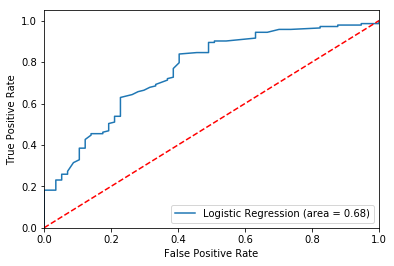

In [24]:
#ROC Curve
logit_roc_auc = roc_auc_score(Y_test, logistic.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, logistic.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

###### <font color=Green> Discussion
 - Accuracy for insample is 75.87 and for out-of-sample is 77.5 which is better than baseline model.
 - Precision of model has improved both for Good Risk and Bad Risk prediction. ROC curve suggests out of sample value of 68%
 - The model works well with 15 variables given by RFE, opposed to all 37 variables because of exclusion of insignificant variables from the model.The leftover variables give a good out of sample accuracy 
 - The final variables in the model seems to be intuitive and has correct coefficient sign as discussed in Data Analysis Section

###  <font color=Red> Experiment 2 : Random Forest

##### <font color=Orange>Experiment 2: Getting best parameters for Random Forest

In [25]:
#Defining dependent and independent parameters
X_train,Y_train,X_test,Y_test=dep_indep(train_data,test_data)

#Seting the Hyper Parameters
param_grid = {"max_depth": [3,5, 7, 10,None],
              "n_estimators":[3,5,10,50,100],
              "max_features": [4,7,15,20,37]}

#Creating the classifier
model = RandomForestClassifier(random_state=2)

grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)

0.7625
{'max_depth': 7, 'max_features': 7, 'n_estimators': 10}


C:\Users\rupal\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


##### <font color=Orange>Experiment 2: Running Random Forest

In [36]:
#Defining dependent and independent parameters
X_train,Y_train,X_test,Y_test=dep_indep(train_data,test_data)

# Defining model
rand_forest = RandomForestClassifier(max_depth=7, max_features=7, n_estimators=10, random_state=2)

#Model fitting and Predictions
rand_forest.fit(X_train, Y_train)
Y_train_pred_2 = rand_forest.predict(X_train)
Y_test_pred_2 = rand_forest.predict(X_test)

#5-fold Cross Validation
SCORES = cross_val_score(rand_forest, X_train, Y_train, cv=5, scoring = "accuracy")
SCORE_2=SCORES.mean()  #Mean

print("SCORE for Train Data",SCORE_2*100)
print("SCORE for Test Data",rand_forest.score(X_test,Y_test)*100)

#Feature Importances
feature_importances = pd.DataFrame(rand_forest.feature_importances_,
                                   index = X_train.columns,
                                    columns=['Importance']).sort_values('Importance',ascending=False)
print("\n Feature_importances: \n",feature_importances)

SCORE for Train Data 76.24377417086605
SCORE for Test Data 72.5

 Feature_importances: 
                         Importance
with_check_acc            0.138566
dur                       0.127114
credit_hist               0.091815
age                       0.083801
no_check_acc              0.063653
property                  0.049498
with_saving_acc           0.046495
loan_purpose_A40          0.031172
installment_rate          0.028389
employment_GT1            0.027651
loan_amount_GT10k         0.027238
status_sex_A92            0.021955
loan_purpose_A49          0.021115
other_installment_A141    0.020384
existing_credits_1to3     0.020149
no_saving_acc             0.019314
other_installment_A143    0.017662
loan_purpose_A46          0.017462
existing_credits_4        0.015569
housing_own               0.015163
status_sex_A93            0.015120
count_liable_people       0.011468
debtor_guarantor_A103     0.011226
loan_purpose_A43          0.010611
debtor_guarantor_A101     0.009502
l

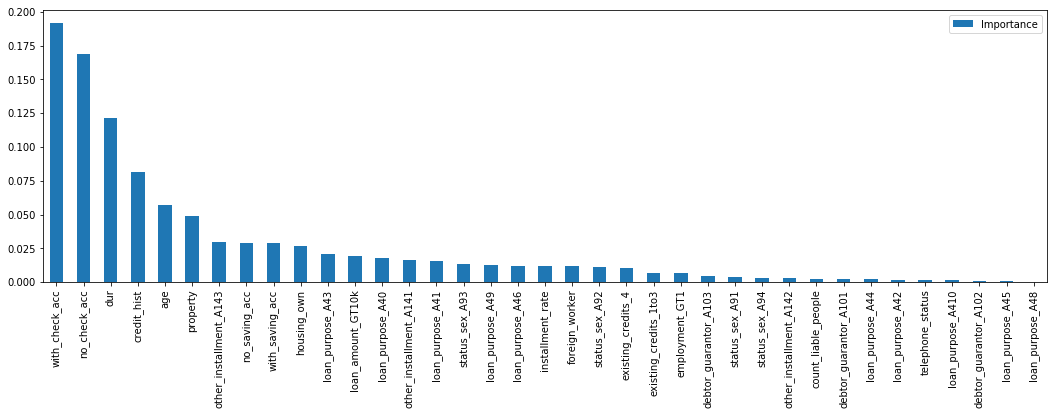

In [27]:
#Bar Plot of Feature Importance
feature_importances.plot.bar(figsize=(18,5))

##### <font color=Orange>Experiment 2: Re-Running Random Forest with Important Parameters only

In [37]:
#Using Important Variables (Significance>2%) in the model
final_param=['with_check_acc','dur','credit_hist','age','no_check_acc','property','with_saving_acc','loan_purpose_A40',
             'installment_rate','employment_GT1','loan_amount_GT10k','status_sex_A92','loan_purpose_A49',
             'other_installment_A141','existing_credits_1to3']

X_train=X_train[final_param]
X_test=X_test[final_param]

#Model fitting and Predictions
rand_forest.fit(X_train, Y_train)
Y_train_pred_2 = rand_forest.predict(X_train)
Y_test_pred_2 = rand_forest.predict(X_test)

#5-fold Cross Validation
SCORES = cross_val_score(rand_forest, X_train, Y_train, cv=5, scoring = "accuracy")
SCORE_2=SCORES.mean()  #Mean

print("SCORE for Train Data",SCORE_2*100)
print("SCORE for Test Data",rand_forest.score(X_test,Y_test)*100)

#Feature Importances
feature_importances = pd.DataFrame(rand_forest.feature_importances_,
                                   index = X_train.columns,
                                    columns=['Importance']).sort_values('Importance',ascending=False)
print("\n Feature_importances: \n",feature_importances)

SCORE for Train Data 74.36483358724949
SCORE for Test Data 72.5

 Feature_importances: 
                         Importance
dur                       0.188408
age                       0.147587
no_check_acc              0.128382
credit_hist               0.090652
with_check_acc            0.069461
property                  0.067526
with_saving_acc           0.059899
installment_rate          0.041975
other_installment_A141    0.036347
loan_purpose_A40          0.032570
employment_GT1            0.030315
status_sex_A92            0.029645
existing_credits_1to3     0.027148
loan_amount_GT10k         0.027094
loan_purpose_A49          0.022992


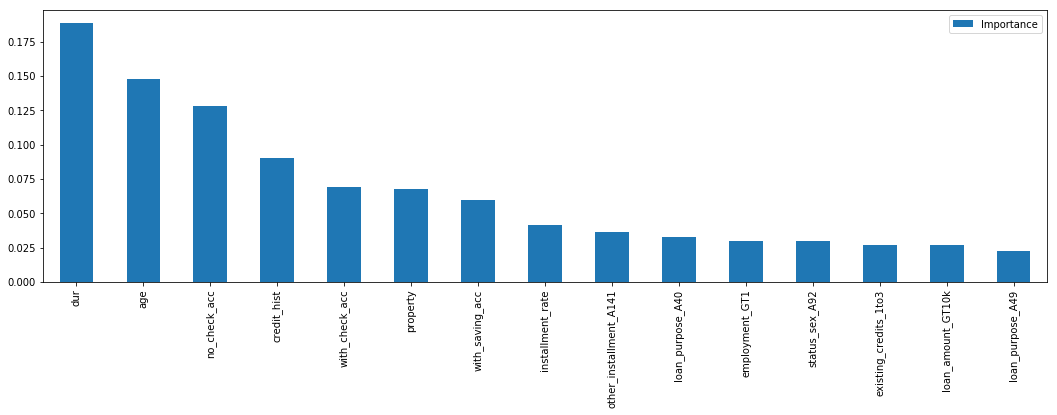

In [38]:
#Bar Plot of Feature Importance
feature_importances.plot.bar(figsize=(18,5))

##### <font color=Orange>Experiment 2: Result & Discussion on Random Forest

In [39]:
# All the metrices and ROC Curve
print("SCORE for Train Data",SCORE_2*100)
print("SCORE for Test Data",rand_forest.score(X_test,Y_test)*100)
print("Metrices:\n",classification_report(Y_test, Y_test_pred_2))

SCORE for Train Data 74.36483358724949
SCORE for Test Data 72.5
Metrices:
               precision    recall  f1-score   support

           0       0.52      0.39      0.44        57
           1       0.78      0.86      0.82       143

   micro avg       0.72      0.72      0.73       200
   macro avg       0.65      0.62      0.63       200
weighted avg       0.71      0.72      0.71       200



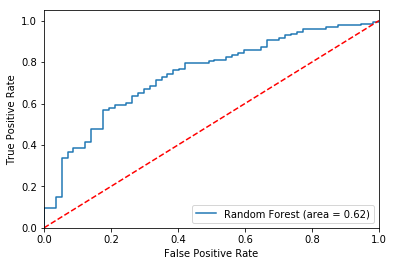

In [40]:
#ROC Curve
rf_roc_auc = roc_auc_score(Y_test, rand_forest.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, rand_forest.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

###### <font color=Green> Discussion
 - Accuracy for insample is 74.36 and for out-of-sample is 72.5 which is better than baseline model but worse than logistic regression
 - Precision of model has improved both for Good Risk and Bad Risk prediction while Recall for Good Risk has deteriorated as expected. ROC curve suggests out of sample value of 62%
 - Feature importance table suggests that around 80% of model is explained by 15 top variables alone. Rest of the variables add very little value to the model

###  <font color=Red> Experiment 3 : Support Vector Machine(SVM)

##### <font color=Orange>Experiment 3: Running SVM

In [32]:
#Defining dependent and independent parameters
X_train,Y_train,X_test,Y_test=dep_indep(train_data,test_data)

# Defining model
svm= SVC(gamma="auto")
svm.probability = True  #This step is required for ROC curve for SVM model

#Model fitting and prediction
svm.fit(X_train, Y_train)

Y_train_pred_3 = svm.predict(X_train)
Y_test_pred_3=svm.predict(X_test)

#5-fold Cross Validation
SCORES = cross_val_score(svm, X_train, Y_train, cv=5, scoring = "accuracy")
SCORE_3=SCORES.mean()  #Mean

##### <font color=Orange>Experiment 3: Result & Discussion on SVM

In [33]:
# All the metrices and ROC Curve
print("SCORE for Train Data",SCORE_3*100)
print("SCORE for Test Data",svm.score(X_test,Y_test)*100)
print("Metrices:\n",classification_report(Y_test, Y_test_pred_3))

SCORE for Train Data 69.73967733114576
SCORE for Test Data 71.0
Metrices:
               precision    recall  f1-score   support

           0       0.47      0.16      0.24        57
           1       0.73      0.93      0.82       143

   micro avg       0.71      0.71      0.71       200
   macro avg       0.60      0.54      0.53       200
weighted avg       0.66      0.71      0.65       200



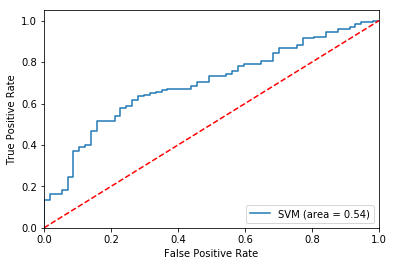

In [34]:
#ROC Curve
svm_roc_auc = roc_auc_score(Y_test, svm.predict(X_test))
fpr, tpr, thresholds = roc_curve(Y_test, svm.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='SVM (area = %0.2f)' % svm_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

###### <font color=Green> Discussion
 - Accuracy for insample is 69.73 and for out-of-sample is 71 which is very close to Baseline model accuracy of 69.63.
 - Precision of model has improved both for Good Risk and Bad Risk prediction. ROC curve suggests out of sample value of 54%
 - The model seems to perform poorly compared to other 2 models

###  <font color=Red> Final Model

###### Logistic Regression is considered to be final model because of highest out of sample accuracy(77.5%) and ROC(68%). It does a good job in differentiating Good Risk from Bad Risk. Please refer to Experiment 3 for more details about the model

In [35]:
##############Setting final model(credit_model) as logistic model##############

credit_model=logistic  #Which is defined in Experiment 1


#Defining final dependent and independent parameters
X_train,Y_train,X_test,Y_test=dep_indep(train_data,test_data)

#Listing Final parameters decided by RFE step
final_param= ['credit_hist', 'foreign_worker', 'loan_purpose_A40', 'loan_purpose_A41', 'loan_purpose_A46', 
              'loan_purpose_A48', 'loan_purpose_A49', 'status_sex_A93', 'debtor_guarantor_A102', 'debtor_guarantor_A103',
              'other_installment_A143', 'with_check_acc', 'no_check_acc', 'no_saving_acc', 'loan_amount_GT10k']

X_train = X_train[final_param]
X_test= X_test[final_param]